<a href="https://colab.research.google.com/github/aarandjel/importance-sampling-with-feedforward-networks/blob/main/Black_Scholes_arithmetic_asian_basket_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling for option pricing with feedforward neural networks

In this Jupyter notebook, we study the problem of reducing the standard error in Monte Carlo simulations when pricing path-dependent options through suitable changes of measure which are induced by feedforward networks.

We consider an arithmetic Asian basket call option in a multivariate Black-Scholes model.

In [ ]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import norm
from tqdm.notebook import trange
from numpy import savetxt, loadtxt
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Dot
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version:  2.6.0
Keras version:  2.6.0


In [ ]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [ ]:
T = 1 # Terminal time
N = 252 # Number of time steps
delta_t = T/N # Time increments
strike = 70.0 # Strike for the call option
r = 0.05 # Interest rate
N_assets = 10 # Number of assets
N_train = 3*10**5 # Size of sample for trainingdata
learnrate = 0.001 # Learning rate for Adam optimizer

In [ ]:
# Check out https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# X_0 = np.around(np.random.uniform(low=40.0, high=50.0, size=(N_assets)), 0)
# mu = np.around(np.random.uniform(low=0.00, high=0.10, size=(N_assets)), 4)
# Sigma = np.around(np.random.uniform(low=-0.30, high=0.30, size=(N_assets, N_assets)), 4)

# savetxt("mBSX_0.csv", X_0, delimiter=",")
# savetxt("mBSmu.csv", mu, delimiter=",")
# savetxt("mBSSigma.csv", Sigma, delimiter=",")

X_0 = loadtxt("mBSX_0.csv", delimiter=",")
mu = loadtxt("mBSmu.csv", delimiter=",")
Sigma = loadtxt("mBSSigma.csv", delimiter=",")

In [ ]:
Sigmaprime = np.dot(Sigma, np.transpose(Sigma)) # This is the variance-covariance matrix of $M_{1} = \Sigma B_{1}$

volvec = np.diag(Sigmaprime)
tilde_mu = mu - 0.5 * volvec

weights = np.divide(mu, np.sqrt(np.diag(Sigmaprime)))
weights = weights / np.sum(weights)

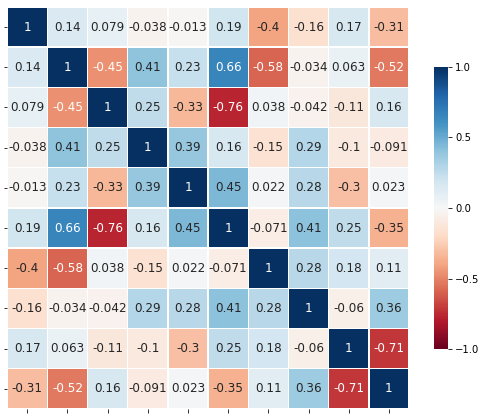

In [ ]:
# Visualizing the correlation matrix of $M_{1}$
v = np.sqrt(np.diag(Sigmaprime))
outer_v = np.outer(v,v)
Rho = Sigmaprime / outer_v
Rho[Sigmaprime == 0] = 0

f, ax = plt.subplots(figsize=(9, 13))

heatmap = sns.heatmap(Rho, square = True, linewidths = .5, cmap="RdBu", 
                      cbar_kws = {'shrink': .4, "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, vmax = 1, annot = True, annot_kws = {"size": 12})

ax.set_yticklabels("")
ax.set_xticklabels("")

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

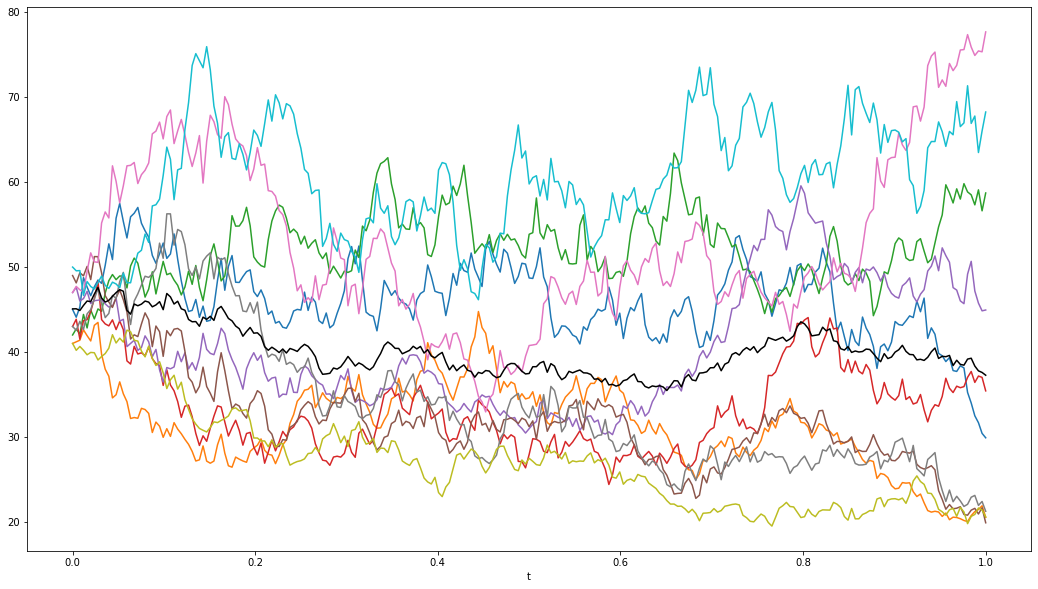

In [ ]:
M = np.dot(Sigma, np.random.normal(0, np.sqrt(delta_t), (N_assets, N)))

M = M + tilde_mu[:, None] * delta_t
M = np.cumsum(np.concatenate((np.zeros((N_assets, 1)), M), axis=1), axis=1)
M = np.multiply(np.exp(M), X_0[:, None])

basket = np.sum(np.multiply(M, weights[:, None]), axis = 0)
    
t = np.linspace(0, T, N+1) 
plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M))
plt.plot(t, np.transpose(basket), color="black")
plt.xlabel("t")
plt.show()

In [ ]:
N_sample = 5000
outcomes = []
counter = 0
 
start_time = time.time()
 
# for i in trange(N_sample):
for i in progressbar(range(N_sample), "Computing: ", 60):
    M = np.dot(Sigma, np.random.normal(0, np.sqrt(delta_t), (N_assets, N)))
    M = M + tilde_mu[:, None] * delta_t
    M = np.cumsum(np.concatenate((np.zeros((N_assets, 1)), M), axis=1), axis=1)
    M = np.multiply(np.exp(M), X_0[:, None])

    basket = np.sum(np.dot(np.transpose(weights), np.sum(M * delta_t, axis=1) / T))
    
    if basket > strike:
        counter += 1
    
    call_option = np.clip(basket - strike, 0, None)
    outcomes = outcomes + [np.exp(-r*T) * 100 * call_option]

elapsed_time = time.time() - start_time
 
mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)
 
print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
 
print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")
print("Probability of positive payoff (MC): ", np.around(counter / N_sample * 100, 2), "%")

Computing: [############################################################] 5000/5000
elapsed time:  00:00:05
Mean (MC):  2.3305
Standard error (MC):  0.5164  ( 22.16 % )
Probability of positive payoff (MC):  0.6 %


In [ ]:
N = 252
delta_t = T/N

In [ ]:
def custom_activation(x):
    return 1.7159*K.tanh(2*x/3)

In [ ]:
layers = []

layer = Dense(N_assets, activation=custom_activation, trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 1.0), 
              bias_initializer=initializers.RandomNormal(0.0, 1.0), 
              name=str(0))
 
layers = layers + [layer]
 
layer = Dense(N_assets, activation="linear", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 1.0), 
              bias_initializer=initializers.RandomNormal(0.0, 1.0), 
              name=str(1))
 
layers = layers + [layer]

In [ ]:
xtrain = ([np.zeros((N_train))] + # t_0
          [delta_t*np.ones((N_train, N_assets))] + # time increment
          [np.zeros((N_train, N_assets))] + # M_0
          [np.tile(X_0, (N_train, 1))] + # X_0
          [np.tile(weights/T, (N_train, 1))] + # basket weights
          [np.zeros((N_train, N_assets))] + # initial value of the payoff
          [np.zeros((N_train, N_assets))] + # initial value of the first part of the stoch exp
          [np.zeros((N_train))] + # initial value of the second part of the stoch exp
          [np.random.normal(0, np.sqrt(delta_t),(N_train, N_assets)) for i in range(N)]) # Brownian increments
 
ytrain = np.zeros((N_train))

In [ ]:
t_0 = Input(shape=(1, ))
d_t = Input(shape=(N_assets, ))
B_0 = Input(shape=(N_assets, ))
X_start = Input(shape=(N_assets, ))
wght = Input(shape=(N_assets, ))
 
c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(N_assets, ))
c_2 = Input(shape=(1, ))
 
inputs = [t_0]+[d_t]+[B_0]+[X_start]+[wght]+[c_0]+[c_1]+[c_2]

M_current = B_0 @ tf.linalg.matrix_transpose(K.constant(Sigma))
X_current = X_start
t_current = t_0
 
for j in range(N):
    
    # Compute part of the basket
    helper_b1 = Lambda(lambda x: x*delta_t)(X_current)
    helper_b2 = Multiply()([wght, helper_b1])
    c_0 = Add()([c_0, helper_b2])
    
    # Choose the drift
    strategy = t_current
    strategy = layers[0](strategy)
    strategy = layers[1](strategy)
    
    # Draw a new increment of M
    incr_B = Input(shape=(N_assets, ))
    inputs = inputs + [incr_B]
    incr_M = incr_B @ tf.linalg.matrix_transpose(K.constant(Sigma))
    M_current = Add()([M_current, incr_M])
    
    # Compute first part of the measure change
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    # Compute second part of the measure change
    helper_e2 = strategy @ tf.linalg.matrix_transpose(K.constant(Sigmaprime))
    helper_e3 = Dot(axes=1)([strategy, helper_e2])
    helper_e4 = Lambda(lambda x: x*delta_t)(helper_e3)
    c_2 = Add()([c_2, helper_e4])

    # Update time and X
    t_current = Lambda(lambda x: x + delta_t)(t_current) 
    
    helper_1 = Lambda(lambda x: tilde_mu * x)(t_current)
    helper_2 = Add()([helper_1, M_current])
    helper_3 = Lambda(lambda x: K.exp(x))(helper_2)
    X_current = Multiply()([X_start, helper_3])
    
helper_e5 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_e6 = Lambda(lambda x: 0.25 * x)(c_2)
 
helper_e7 = Add()([helper_e5, helper_e6])
helper_e8 = Lambda(lambda x: K.exp(x))(helper_e7)
 
c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
c_0 = Lambda(lambda x: K.relu(x - strike))(c_0)
 
c_0 = Multiply()([c_0, helper_e8])
 
outputs = [c_0]

In [ ]:
adam = optimizers.Adam(learning_rate=learnrate)
 
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam, loss="mean_squared_error", metrics=["mse"])

# model.summary()

In [ ]:
# K.set_value(model.optimizer.learning_rate, 0.001)

In [ ]:
stopping_rule = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights=True)

In [ ]:
history = model.fit(x=xtrain, y=ytrain, epochs=500, verbose = 1, batch_size=1024, validation_split=0.2, callbacks=[stopping_rule])

Epoch 1/500
235/235 [==============================] - 82s 157ms/step - loss: 58337752.0000 - mse: 58337752.0000 - val_loss: 16325543.0000 - val_mse: 16325543.0000
Epoch 2/500
 25/235 [==>...........................] - ETA: 18s - loss: 14291233.0000 - mse: 14291233.0000

KeyboardInterrupt: 

In [ ]:
# model.save("model_BS")
model_saved = load_model("model_BS", custom_objects={"custom_activation": custom_activation})

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# print(history.history.keys())

plt.figure(figsize=(18, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

NameError: name 'history' is not defined

<Figure size 1296x720 with 0 Axes>

In [ ]:
#for i in range(25):
#    print(i)
#    print(model.layers[i].get_weights())

In [ ]:
N = 252
delta_t = T/N

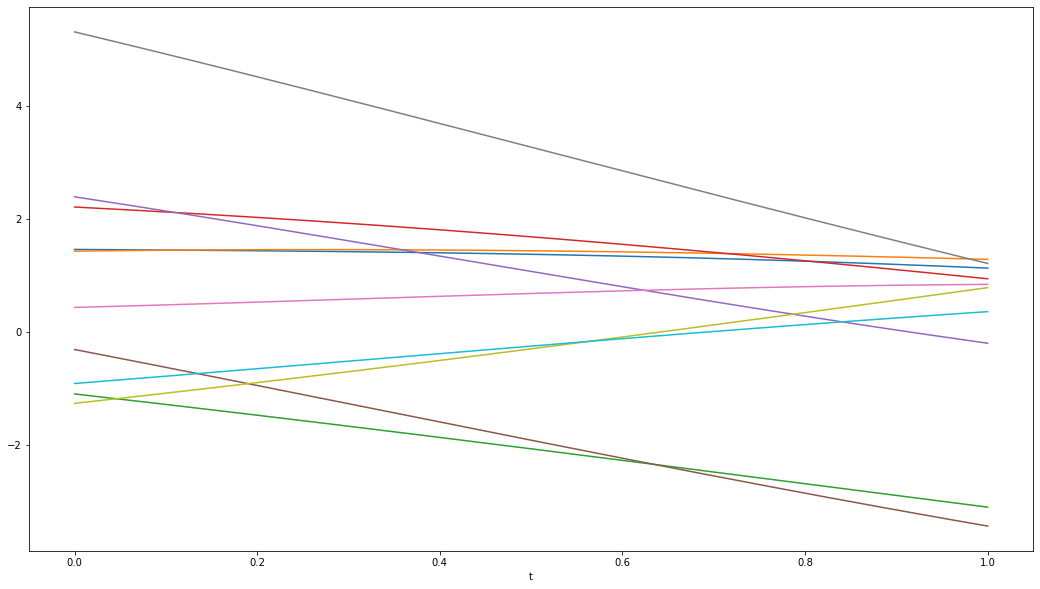

In [ ]:
# Visualizing the feedforward neural network

model_test = keras.Sequential()
model_test.add(Dense(N_assets, activation=custom_activation, name="layer1", input_shape=(1, )))
model_test.add(Dense(N_assets, activation="linear", name="layer2"))
 
model_test.build()
 
model_test.layers[0].set_weights(model_saved.layers[7].get_weights())
model_test.layers[1].set_weights(model_saved.layers[13].get_weights())
 
t = np.linspace(0, T, N+1)
learnedstrat = model_test.predict(t)
 
plt.figure(figsize=(18, 10))
plt.plot(t, learnedstrat)
plt.xlabel("t")
plt.show()

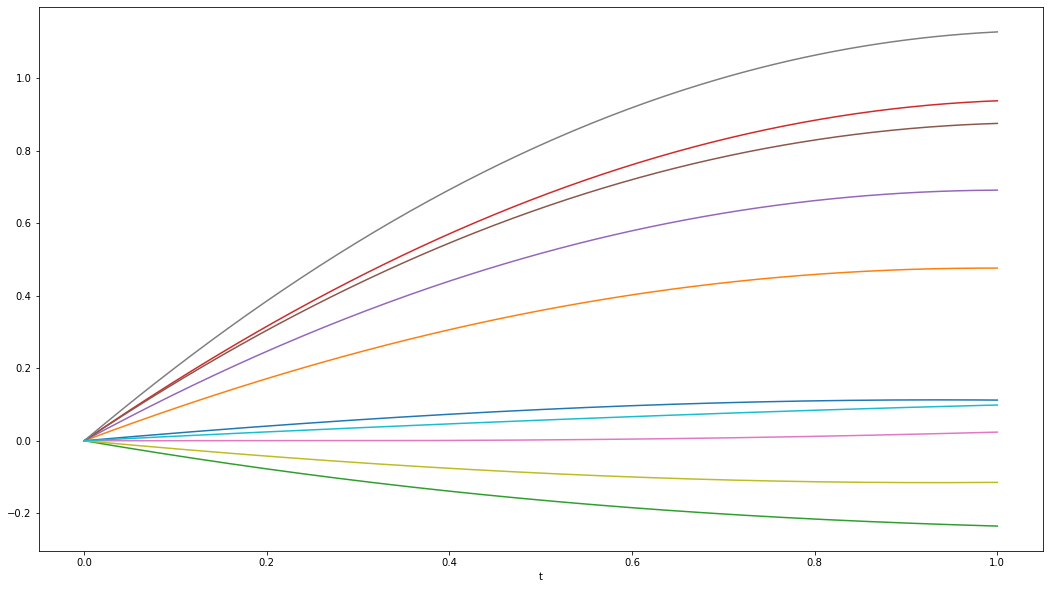

In [ ]:
# Visualizing the drift

normdrift = 0
driftdelta = []
driftcomponent = [np.zeros((N_assets))]
driftdummy = np.zeros((N_assets))

for i in range(N):
    normdrift = normdrift + np.dot(np.transpose(learnedstrat[i,:]), np.dot(Sigmaprime, learnedstrat[i,:])) * delta_t

    driftdummy = driftdummy + np.dot(Sigmaprime, learnedstrat[i,:]) * delta_t
    driftcomponent = driftcomponent + [driftdummy]

    driftdelta = driftdelta + [np.dot(Sigmaprime, learnedstrat[i,:]) * delta_t]

driftdelta = np.transpose(np.asarray(driftdelta))

plt.figure(figsize=(18, 10))
plt.plot(t, driftcomponent)
plt.xlabel("t")
plt.show()

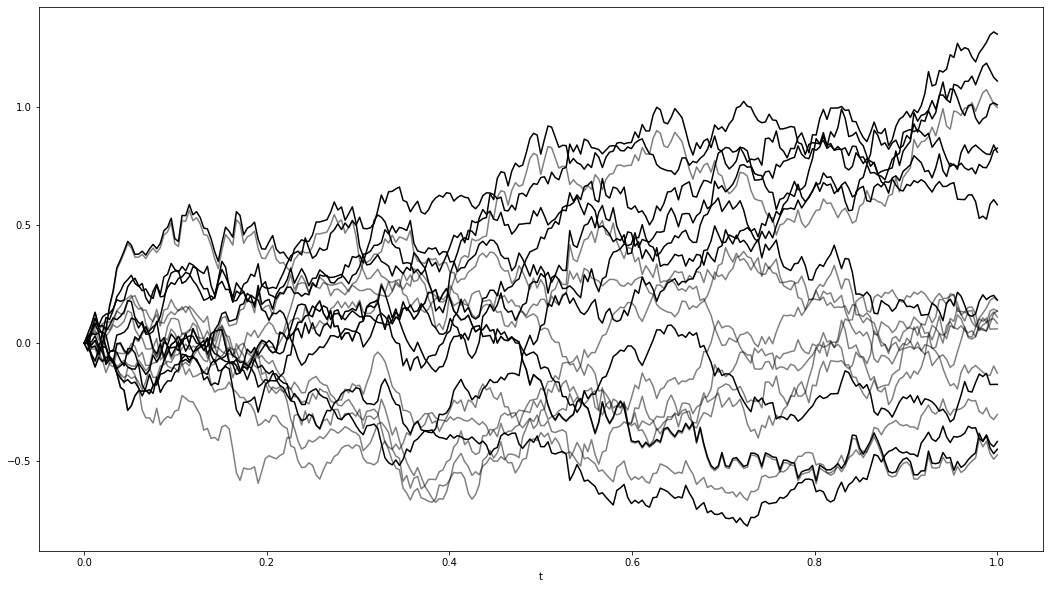

In [ ]:
# Visualizing the drift adjustment of M for one sample path

M_random = np.dot(Sigma, np.random.normal(0, np.sqrt(delta_t), (N_assets, N)))

M_MC = np.cumsum(np.concatenate((np.zeros((N_assets, 1)), M_random), axis=1), axis=1)
M_IS = np.cumsum(np.concatenate((np.zeros((N_assets, 1)), M_random + driftdelta[:,:N]), axis=1), axis=1)

plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M_MC), color = "black", alpha = 0.50, label="without drift adjustment")
plt.plot(t, np.transpose(M_IS), color = "black", label="with drift adjustment")
plt.xlabel("t")
plt.show()

In [ ]:
N_reps = 10
N_sample = 5000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []

counter_pos_MC = []
counter_pos_IS = []
 
# for k in trange(N_reps):
for k in progressbar(range(N_reps), "Computing: ", 60):

    outcomes_MC = []
    outcomes_IS = []
    
    outcomes_pos_MC = 0
    outcomes_pos_IS = 0
    
    for i in range(N_sample):
        
        M_random = np.dot(Sigma, np.random.normal(0, np.sqrt(delta_t), (N_assets, N)))
    
        ##########
    
        M_MC = M_random + tilde_mu[:, None] * delta_t
        M_MC = np.cumsum(np.concatenate((np.zeros((N_assets, 1)), M_MC), axis=1), axis=1)
        M_MC = np.multiply(np.exp(M_MC), X_0[:, None])
        
        basket = np.sum(np.dot(np.transpose(weights), np.sum(M_MC * delta_t, axis=1) / T))
        
        if basket > strike:
            outcomes_pos_MC += 1
        
        call_MC = np.clip(basket - strike, 0, None)
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * call_MC]
 
        ##########

        M_0 = M_random + driftdelta[:,:N]

        M_IS = M_0 + tilde_mu[:, None] * delta_t
        M_IS = np.cumsum(np.concatenate((np.zeros((N_assets, 1)), M_IS), axis=1), axis=1)
        M_IS = np.multiply(np.exp(M_IS), X_0[:, None])

        C0 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_random), axis=1), axis=0)
        C1 = normdrift
        adjustment = np.exp(-1 * C0 - 0.5 * C1)
    
        basket = np.sum(np.dot(np.transpose(weights), np.sum(M_IS * delta_t, axis=1) / T))
        
        if basket > strike:
            outcomes_pos_IS += 1
        
        call_IS = np.clip(basket - strike, 0, None)
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * call_IS * adjustment]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    counter_pos_MC = counter_pos_MC + [outcomes_pos_MC / N_sample * 100]
    counter_pos_IS = counter_pos_IS + [outcomes_pos_IS / N_sample * 100]
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Computing: [############################################################] 10/10
total elapsed time:  00:00:14


In [ ]:
print("Average MC estimate: ", np.around(np.mean(means_MC), 4))
print("Average IS estimate: ", np.around(np.mean(means_IS), 4))
print("Average standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Average standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Average variance ratio: ", np.around(np.mean(varratio)))
print("Average probability of positive payoff (MC): ", np.around(np.mean(counter_pos_MC), 2), "%")
print("Average probability of positive payoff (IS): ", np.around(np.mean(counter_pos_IS), 2), "%")

Average MC estimate:  2.5386
Average IS estimate:  2.6931
Average standard error (MC):  0.6323  ( 24.91 % )
Average standard error (IS):  0.0854  ( 3.17 % )
Average variance ratio:  74.0
Average probability of positive payoff (MC):  0.6 %
Average probability of positive payoff (IS):  54.35 %


mean MC estimate:   2.5386
mean IS estimate:  2.6931


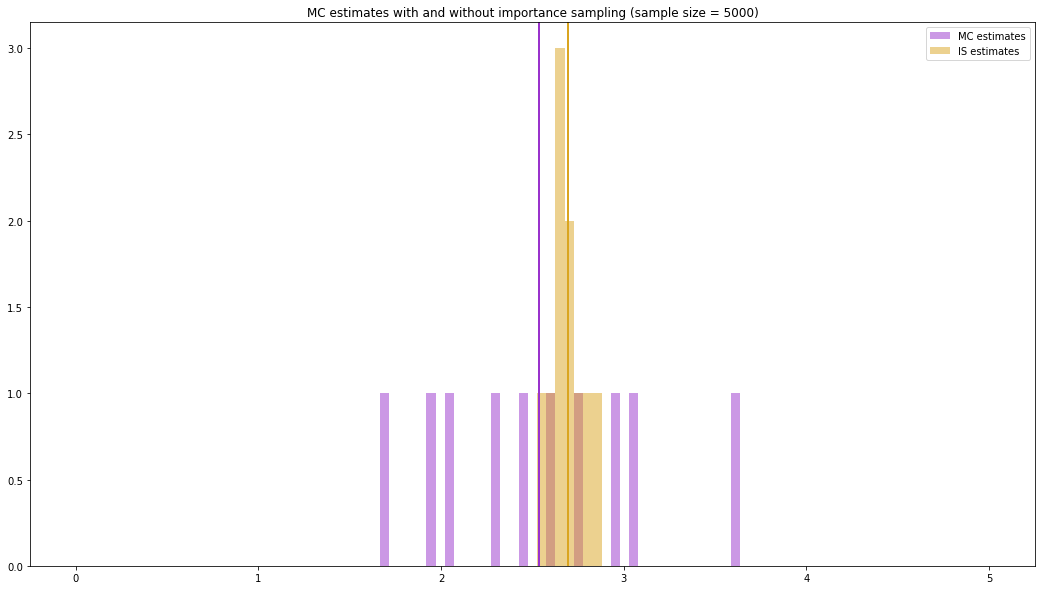

In [ ]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(0.00, 5.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   0.6323
mean IS estimate standard error:  0.0854


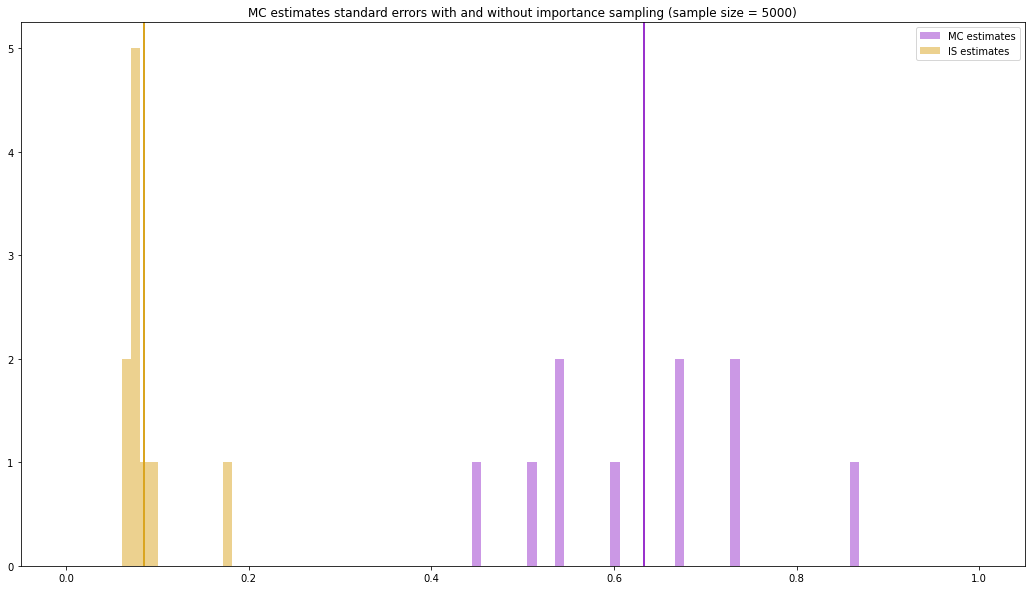

In [ ]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 1.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

mean MC probability of positive payoff:   0.6
mean IS probability of positive payoff:  54.35


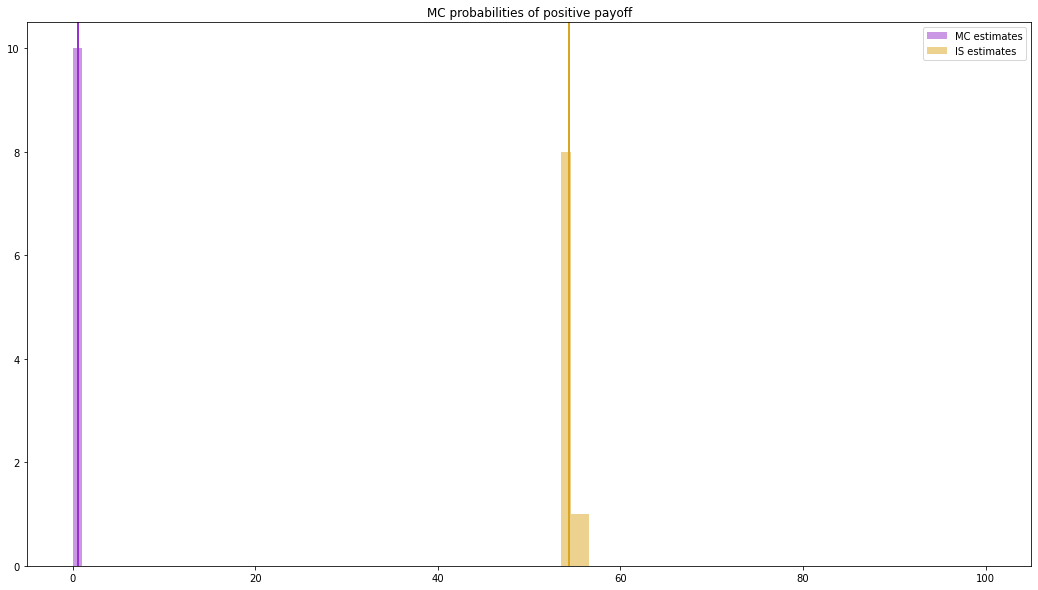

In [ ]:
print("mean MC probability of positive payoff:  ", np.around(np.mean(counter_pos_MC), 2))
print("mean IS probability of positive payoff: ", np.around(np.mean(counter_pos_IS), 2))
 
bins = np.linspace(0.00, 100.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(counter_pos_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(counter_pos_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(counter_pos_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(counter_pos_IS), color="goldenrod", linewidth=2)
plt.title("MC probabilities of positive payoff")
plt.legend(loc="upper right")
plt.show()

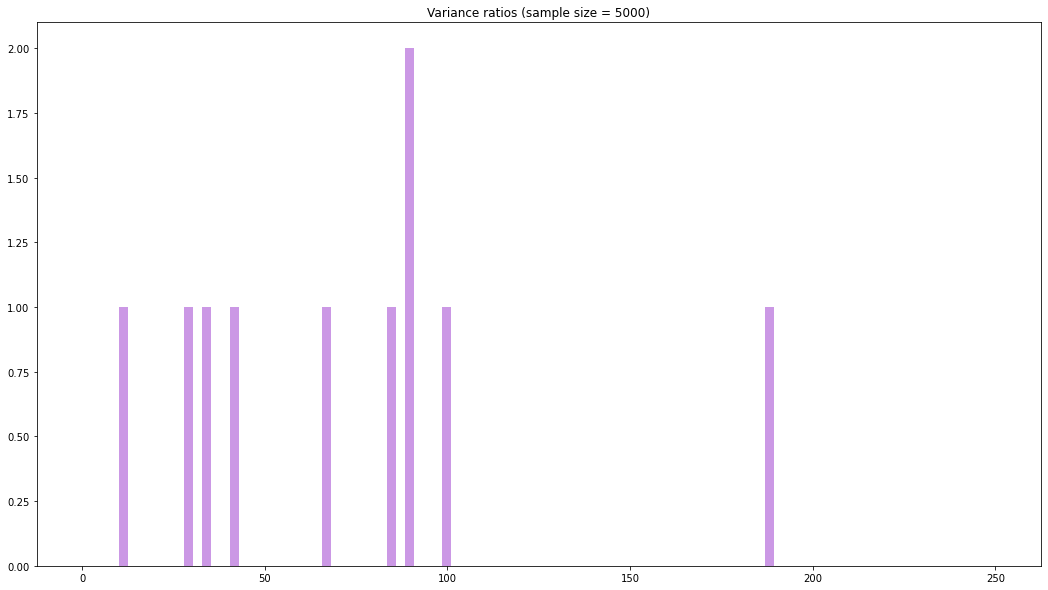

In [ ]:
bins = np.linspace(0.00, 250.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.title("Variance ratios (sample size = 5000)")
plt.show()

In [ ]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'prob pos MC': counter_pos_MC,
        'prob pos IS': counter_pos_IS,
        'varratio': np.around(varratio)}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'prob pos MC', 'prob pos IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(50))

    mean MC   mean IS  stderr MC  stderr IS  prob pos MC  prob pos IS  \
9  1.928903  2.808437   0.600078   0.174005         0.44        54.44   
8  2.051228  2.745024   0.513100   0.094244         0.50        54.34   
0  1.678353  2.841943   0.445362   0.077070         0.40        55.16   
5  2.284294  2.724018   0.542509   0.084716         0.62        54.00   
1  2.595983  2.662462   0.541418   0.065914         0.72        56.16   
3  2.436884  2.644794   0.668373   0.072573         0.52        53.96   
7  2.751170  2.708656   0.673266   0.071163         0.68        54.26   
6  2.969568  2.646479   0.734577   0.077193         0.64        53.94   
2  3.066139  2.586703   0.736962   0.073538         0.72        53.58   
4  3.623902  2.562060   0.867504   0.063167         0.72        53.62   

   varratio  
9      12.0  
8      30.0  
0      33.0  
5      41.0  
1      67.0  
3      85.0  
7      90.0  
6      91.0  
2     100.0  
4     189.0  
